<a href="https://colab.research.google.com/github/sogangori/choongang20/blob/master/cnn_2_number_with_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2 자리수 숫자, 공백 CNN 분류기 

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [0]:
tf.keras.backend.set_floatx('float64')

In [75]:
x, y = load_digits(return_X_y=True)
x.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

학습데이터와 테스트 데이터를 나눕니다

In [83]:
m = len(y)//2
x_test = x[m:m*2]
y_test = y[m:m*2]
x_test = np.reshape(x_test, [-1, 8, 8])
x_test.shape, y_test.shape

((898, 8, 8), (898,))

이미지를 2개씩 좌우로 붙여서 합성데이터를 만듭니다


In [84]:
x_test_l, x_test_r = np.split(x_test, 2, axis=0) 
x_test_lr = np.concatenate((x_test_l, x_test_r), axis=2)
y_test_l, y_test_r = np.split(y_test, 2, axis=0) 
y_test = np.stack((y_test_l, y_test_r), -1)
x_test_lr.shape, y_test.shape

((449, 8, 16), (449, 2))

우측에 비어있는 이미지를 붙여서 한자리수 데이터를 만듭니다

In [91]:
BLANK = 10 #'없음' 을 나타내는 기호
x_test_blank = np.concatenate((x_test_l, np.zeros_like(x_test_r)), axis=2)
y_test_blank = np.stack((y_test_l, np.zeros_like(y_test_l) + BLANK), 1)#좌측 영상의 y와 빈 영상의 y를 통합

x_test_set = np.concatenate((x_test_lr, x_test_blank), 0)# 두자리수 영상과 한자리수 영상을 통합
y_test_set = np.concatenate((y_test, y_test_blank), 0)#두자리수 y와 한자리수 y 를 통합
x_test_set.shape, y_test_set.shape

((898, 8, 16), (898, 2))

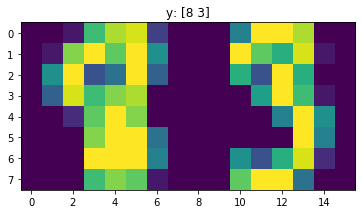

In [101]:
i = 0
plt.title('y: '+str(y_test_set[i]))
plt.imshow(x_test_set[i].reshape((8,-1)))

In [0]:
class MyModel(keras.Model): # github.com/sogangori/choongang20/ 
  def __init__(self):    
    super(MyModel, self).__init__()
    self.k = 10+1 # 클래스 갯수 
    self.seq = 2 # 자릿수
    self.opt = tf.optimizers.SGD(learning_rate=0.01)#Stochatic Gradient Descent 확률적 경사 하강
    self.conv0 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv1 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.relu)
    self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(units=self.k * self.seq)
  
  def call(self, x):
    #x (1797, 64)
    x_4d = tf.reshape(x, [-1,8,8*2,1]) 
    x_4d = tf.cast(x_4d, tf.float32)
    net = self.conv0(x_4d)
    net = self.pool0(net)
    net = self.conv1(net)
    net = self.pool1(net)
    net = self.flatten(net)    
    h = self.dense(net)
    h = tf.reshape(h, [-1, self.seq, self.k]) # 2:두자리수, 10:10개의 클래스 
    h = tf.nn.softmax(h, axis=2)
    return h

  def get_loss(self, y, h):
    #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
    h = tf.clip_by_value(h, 1e-8, 1 - 1e-8) # h 가 0이나 1이 되지 않도록 하는 안전장치 
    cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
    loss = tf.reduce_mean(cross_entropy)
    return loss

  def get_accuracy(self, y, h):    
    predict = tf.argmax(h, -1)
    is_equal = tf.equal(y, predict)
    self.acc = tf.reduce_mean(tf.cast(is_equal, tf.float32)) # True > 1, False > 0 로 cast
    self.acc_all = tf.reduce_mean(tf.cast(tf.reduce_all(is_equal, axis=1), tf.float32))

  def fit(self, x, y, epoch=1):
    # x : (m, 8, 16), y: (m, 2)    
    y_hot = tf.one_hot(y, depth=self.k, axis=-1)#(m, 2, 10)  
    for i in range(epoch):
      with tf.GradientTape() as tape: #경사 기록 장치
        h = self.call(x)
        loss = self.get_loss(y_hot, h)        
      grads = tape.gradient(loss, self.trainable_variables) #경사 계산
      self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
      self.get_accuracy(y, h)
      if i%10==0:
        print('%d/%d loss:%.3f acc:%.3f acc_all:%.3f'%(i, epoch, loss, self.acc, self.acc_all))
model = MyModel()

In [37]:
model.fit(x_test_set, y_test_set, epoch=500) #학습 

0/500 loss:0.215 acc:0.400 acc_all:0.129
10/500 loss:0.215 acc:0.401 acc_all:0.130
20/500 loss:0.215 acc:0.401 acc_all:0.130
30/500 loss:0.215 acc:0.402 acc_all:0.130
40/500 loss:0.215 acc:0.403 acc_all:0.133
50/500 loss:0.215 acc:0.403 acc_all:0.133
60/500 loss:0.215 acc:0.403 acc_all:0.133
70/500 loss:0.215 acc:0.403 acc_all:0.133
80/500 loss:0.214 acc:0.405 acc_all:0.136
90/500 loss:0.214 acc:0.406 acc_all:0.136
100/500 loss:0.214 acc:0.406 acc_all:0.136
110/500 loss:0.214 acc:0.406 acc_all:0.136
120/500 loss:0.214 acc:0.407 acc_all:0.136
130/500 loss:0.214 acc:0.407 acc_all:0.136
140/500 loss:0.214 acc:0.409 acc_all:0.136
150/500 loss:0.214 acc:0.408 acc_all:0.135
160/500 loss:0.214 acc:0.409 acc_all:0.135
170/500 loss:0.214 acc:0.409 acc_all:0.135
180/500 loss:0.214 acc:0.410 acc_all:0.135
190/500 loss:0.214 acc:0.410 acc_all:0.135
200/500 loss:0.213 acc:0.411 acc_all:0.136
210/500 loss:0.213 acc:0.411 acc_all:0.136
220/500 loss:0.213 acc:0.412 acc_all:0.137
230/500 loss:0.213 acc

In [38]:
# 테스트셋의 성능
h = model(x_test_set)
model.get_accuracy(y_test_set, h)
print('개별정확도',model.acc.numpy(),'두자리 모두 맞춘 정확도', model.acc_all.numpy())

개별정확도 0.41926503 두자리 모두 맞춘 정확도 0.14476615
